# CMRM Homework Assignment No. 1 (HW1)

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
# import other libraries
import deeplake #used to load the dataset
import pickle #used to save and load the model

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler 
from sklearn.svm import SVC #import the classifier 
from sklearn import metrics #for the accuracy and to compute and display the confusion matrix

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.8) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## Question 1

In [2]:
# Import dataset
ds = deeplake.load('hub://activeloop/gtzan-genre') 
ds.summary()

/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-genre



\

hub://activeloop/gtzan-genre loaded successfully.



Dataset(path='hub://activeloop/gtzan-genre', read_only=True, tensors=['audio', 'genre'])

 tensor      htype              shape             dtype  compression
 -------    -------            -------           -------  ------- 
  audio      audio     (1000, 660000:675808, 1)   None      wav   
  genre   class_label         (1000, 1)          uint32    None   


In [3]:
Fs = 22050
n_samples = 29 * Fs # duration in samples 
n_elements = 1000 #number of elements in the dataset

# Define downsampling factors
sub_train = 10 
sub_test = 52

train_ind = list(range(0, n_elements, sub_train)) #defining the list of indices for the training set 
test_ind = list(range(11, n_elements, sub_test)) #defining the list of indices for the test set


# Extract classes
genre_names = ['pop', 'metal', 'classical', 'rock', 'blues', 'jazz', 'hiphop', 'reggae', 'disco', 'country']

genre_train = [ds.genre[i].data()['text'] for i in train_ind] #extraction of the training-set for genre

genre_test = [ds.genre[i].data()['text']for i in test_ind] #extraction of the test-set for genre 

print("The shape of genre_train is: ", np.shape(genre_train))
print("The shape of genre_test is: ", np.shape(genre_test))

# Extract training set
audio_train = [ds.audio[i].data()['value'][:n_samples][:,0] for i in tqdm(train_ind)] #extraction of the training-set for audio
print("The shape of audio_train list is: ", np.shape(audio_train))

# Extract test set
audio_test = [ds.audio[i].data()['value'][:n_samples][:,0] for i in tqdm(test_ind)] #extraction of the test-set for audio
print("The shape of audio_test list is: ", np.shape(audio_test))

The shape of genre_train is:  (100, 1)
The shape of genre_test is:  (20, 1)


/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/deeplake/core/tensor.py:704: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

The shape of audio_train list is:  (100, 639450)


  0%|          | 0/20 [00:00<?, ?it/s]

The shape of audio_test list is:  (20, 639450)


In [4]:
#definition of the function print_plot
def print_plot(y, x, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(10, 4))
    plt.xlim([x[0], x[-1]])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    if (np.shape(x)[0] == np.shape(y)[0]):
        plt.plot(x, y)
    else:
        plt.plot(y, color='blue')
        plt.show(x, y)

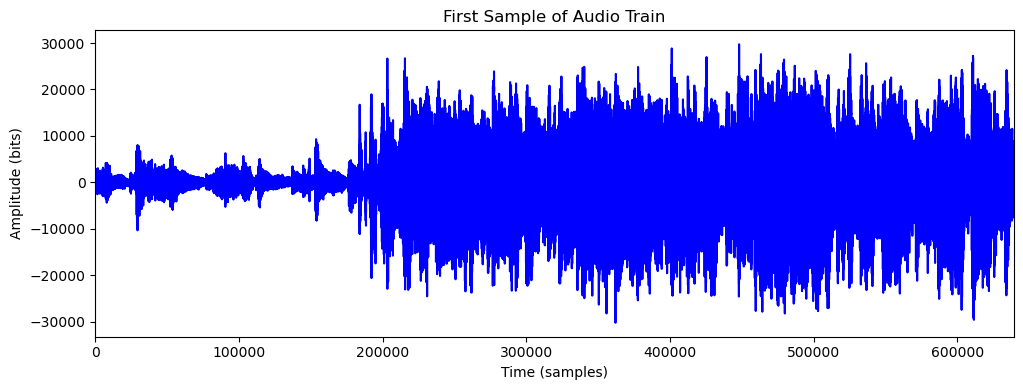

In [5]:
# Plot the first wav of the training set
print_plot(y=audio_train[0], x=[0, audio_train[0].shape[0]], title='First Sample of Audio Train', xlabel='Time (samples)', ylabel='Amplitude (bits)')

## Question 2

In [6]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(-1, 1)) #MinMaxScaler scales datas into a fixed range (-1,1)

#applying the fit method of the scaler to audio_train and audio_test in order to normalised their values into the fixed range (-1, 1) 
audio_train_scaled = scaler.fit_transform(audio_train)  
audio_test_scaled = scaler.fit_transform(audio_test)

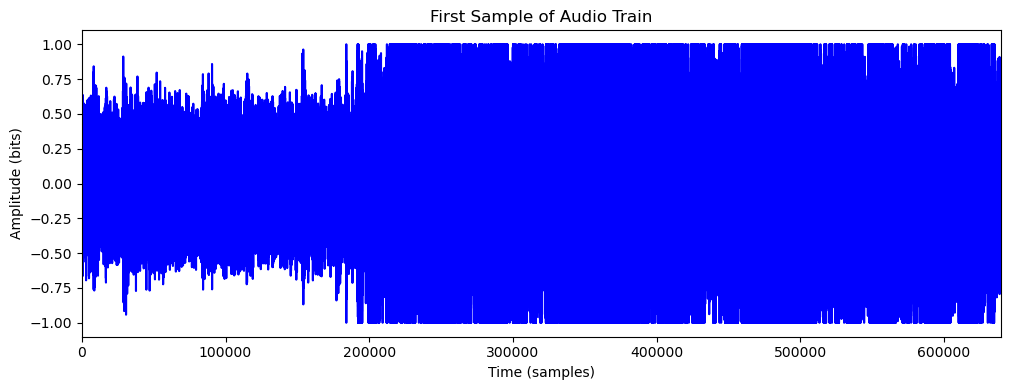

In [7]:
# Plot the first wav in the train set after preprocessing
print_plot(y=audio_train_scaled[0], x=[0, audio_train_scaled[0].shape[0]], title='First Sample of Audio Train', xlabel='Time (samples)', ylabel='Amplitude (bits)')

In [8]:
# Compute local average
def compute_local_average(x, M):
    """Compute local average of signal

    Args:
        x: Signal
        M: M is the size of the averaging window, and it is given in samples, 

    Returns:
        local_average: Local average signal
    """
    L = len(x) #length of the signal
    local_average = np.zeros(L) #initializing of a zeros vector with the length L
    for m in range(L): 
        a = max(m - M, 0) #to crop the window when its boundaries exceed the vector support
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b]) #compute the local average
    return local_average

# Compute the principal argument
def principal_argument(x):
    """Principal argument function 
    
    Args:
        x: value (or vector of values)
        
    Returns:
        y: Principal value of x
    """
    
    y = np.mod(x + 0.5, 1) - 0.5 #the principal argument function maps phase difference into the range [-0.5, 0.5]
    
    return y

# Compute the Phase-Based Novelty function
def compute_phase_novelty(x, Fs=1, N=2048, H=64, M=40, norm=True, plot=False, title='Novelty Function'):
    """Compute phase-based novelty function

    Args:
        x: Signal
        Fs: Sampling rate
        N: Window size
        H: Hop size
        M: Total length in samples of centric window  used for local average
        norm: Apply max norm (if norm==True)
        plot: plot novelty (if plot==True)

    Returns:
        nov: Phase-based novelty function
        Fs_nov: Novelty rate
    """
    
    # Compute the STFT
    x_stft = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')  
    
    # Compute the novelty rate
    Fs_nov = Fs / H  
    
    # Extract the phase and use principal_argument
    phase = np.angle(x_stft)/(2*np.pi)
    
    phase_diff = np.diff(phase, axis=1) #compute the derivative
    phase_diff_1 = principal_argument(phase_diff)
    phase_diff_2 = np.diff(phase_diff_1, axis=1)
    phase_diff_2 = principal_argument(phase_diff_2)
    
    # Accumulation over frequency axis
    phase_sum = np.sum(np.abs(phase_diff_2), axis=0) 
    phase_sum = np.concatenate((phase_sum, np.array([0, 0])))
    
    # Local average subtraction and half-wave rectification
    if M > 0:
        local_average = compute_local_average(phase_sum, M)
        nov = phase_sum - local_average
        nov[nov < 0] = 0
        
    
    # Normalization  
    if norm: 
        max_value = np.max(np.abs(nov))
        nov = nov / max_value
       
    # Plot
    if plot:
        time_axis = np.arange(nov.shape[0]) / Fs_nov
        print_plot(y=nov, x=time_axis, title=title, xlabel='Time (samples)', ylabel='')
        
    return nov, Fs_nov

(array([0.        , 0.        , 0.        , ..., 0.07614468, 0.08857079,
        0.0303146 ]),
 344.53125)

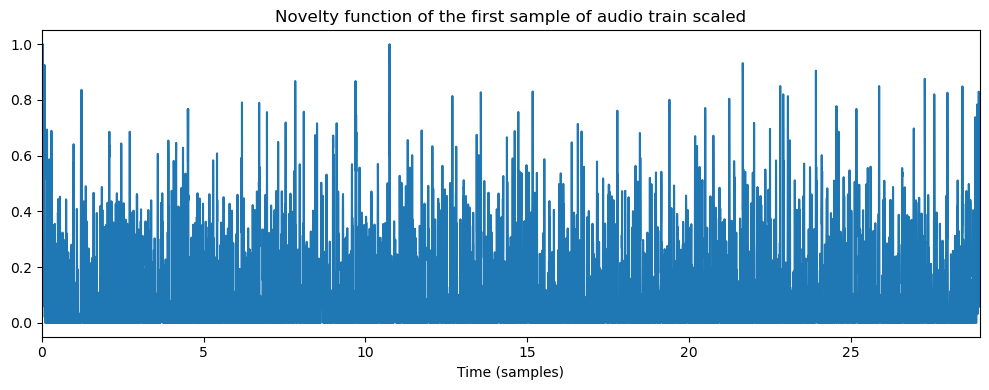

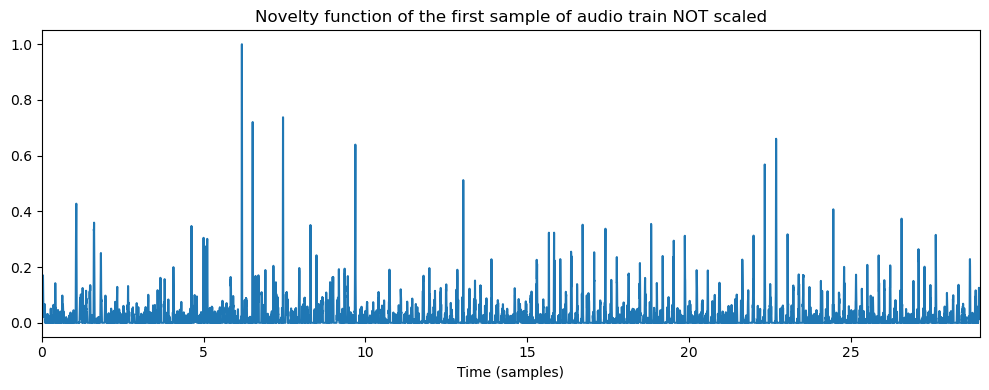

In [9]:
# Test the novelty function on the first wav in the train set
compute_phase_novelty(x=audio_train_scaled[0], Fs=Fs, N=2048, H=64, M=40, norm=True, plot=True, title='Novelty function of the first sample of audio train scaled')
compute_phase_novelty(x=audio_train[0], Fs=Fs, N=2048, H=64, M=40, norm=True, plot=True, title='Novelty function of the first sample of audio train NOT scaled')

## Question 3

In [10]:
def compute_feature_vector(x, Fs, N=2048, H=128):
    """Compute the feature vector 

    Args:
        x: Input signal
        Fs: Sampling rate
        N: Window length
        H: Hop size

    Returns:
        f_vector: Feature vector
    """
    
    # Compute rhythmic features
    phase_novelty, Fs_nov = compute_phase_novelty(x=x, Fs=Fs, N=N, H=H)
    phase_nov_std = np.std(phase_novelty) 
    phase_nov_mean = np.mean(phase_novelty)  

    tempogram = librosa.feature.tempogram(y=phase_novelty, sr=Fs_nov, hop_length=H, win_length=N)
    
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=x, hop_length=H) 
    
    zc_std = np.std(zero_crossing_rate)
    zc_mean = np.mean(zero_crossing_rate)
    
    s_flux = librosa.onset.onset_strength(y=x, sr=Fs)
    
    sf_std = np.std(s_flux)
    sf_mean = np.mean(s_flux)
    
    x_beat = librosa.beat.tempo(y=x, sr=Fs, onset_envelope = s_flux, hop_length=H)
    
    # Concatenate numpy arrays
    f_vector = np.concatenate(
        [phase_novelty,
         Fs_nov,
         phase_nov_std,
         phase_nov_mean,
         tempogram,
         zero_crossing_rate,
         zc_std,
         zc_mean,
         s_flux,
         sf_std,
         sf_mean,
         x_beat
        ], axis=None)
    return f_vector

In [11]:
# Compute feature vector for all the audio files inside the training set

N = 2048
H = 128

#definition of the function compute_fvectors: it calls the compute_feature_vector function to create the train and test feature vectors
def compute_fvectors():
    
    train_fvector = [compute_feature_vector(x=audio_train_scaled[i], Fs=Fs, N=N, H=H) for i in tqdm(list(range(0, np.size(train_ind))))]
    test_fvector = [compute_feature_vector(x=audio_test_scaled[i], Fs=Fs, N=N, H=H) for i in tqdm(list(range(0, np.size(test_ind))))]
    
    return train_fvector, test_fvector

train_fvector, test_fvector = compute_fvectors()

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/ln/rh_16fds3c3f6zwtz0w3p1ww0000gp/T/ipykernel_4176/2749448222.py:31: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  x_beat = librosa.beat.tempo(y=x, sr=Fs, onset_envelope = s_flux, hop_length=H)


  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
# Check train_fvector and test_fvector shapes
print("The shape of the train_vector is: ", np.shape(train_fvector))
print("The shape of the test_vector is: ", np.shape(test_fvector))

The shape of the train_vector is:  (100, 93167)
The shape of the test_vector is:  (20, 93167)


## Question 4

In [13]:
# Definition of model's parameters 
C = 1
kernel = "linear"

#creation the directory 'my_model' (if it not exists)
if not os.path.exists('my_model/'):
    os.mkdir('my_model/')

#creation of model SVC
model = SVC(C=C, kernel=kernel)

#Training the model using the training set
model.fit(train_fvector, genre_train)

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, kernel='linear')

In [14]:
#Definition of the save_and_load_Model function:
#it save and load a new model
#load an existing model 

def save_and_load_Model(): 
    file_path = os.path.join('my_model/',f'svc_{kernel}_C_{C}_N_{N}_H_{H}') 
    
    
    if not os.path.exists(file_path):
        model = SVC(C=C, kernel=kernel)
        model.fit(train_fvector, genre_train)

        #creation of the model in the directory my_model
        with open(file_path, 'wb') as file:  
            pickle.dump(model, file)
            
        #the variable par_combination show which are the model parameters 
        par_combination = f"svc(C={C}, kernel={kernel}, N={N}, H={H})"
        print("Creation of the model with the parameters combination:", par_combination)

        #loading of the model just created
        with open(file_path, 'rb') as file:  
            model = pickle.load(file)
        print("Loading of the model with the parameters combination:", par_combination) 

    else:
        #if the model already exists
        with open(file_path, 'rb') as file:  
            model = pickle.load(file)
        par_combination = f"svc(C={C}, kernel={kernel}, N={N}, H={H})"
        print("Loading of the model with the parameters combination:", par_combination) 
        

#definition of the print_accuracy function     
def print_accuracy(fvector, genre):
    prediction = model.predict(fvector)
    ac = metrics.accuracy_score(genre, prediction)*100
    print("Accuracy:",ac,"% given the parameters C =", C, ", kernel =", kernel,", N =", N,"and H =", H)

In [15]:
#call the function save_and_load_Model to save and try different model with different parameters
save_and_load_Model()

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Creation of the model with the parameters combination: svc(C=1, kernel=linear, N=2048, H=128)
Loading of the model with the parameters combination: svc(C=1, kernel=linear, N=2048, H=128)


In [16]:
# Print the accuracy on the training set
print_accuracy(train_fvector, genre_train) 

Accuracy: 100.0 % given the parameters C = 1 , kernel = linear , N = 2048 and H = 128


## Question 5

In [17]:
#Classify the test set
#compute the prediction for the test set
prediction = model.predict(test_fvector)

In [18]:
# Print the accuracy 
print_accuracy(test_fvector, genre_test)

Accuracy: 25.0 % given the parameters C = 1 , kernel = linear , N = 2048 and H = 128


In [19]:
#Definition of print_ConfusionMatrix function in order to print the matrix 
def print_ConfusionMatrix():
    cm=metrics.confusion_matrix(genre_test, prediction, labels=genre_names)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = genre_names)
    cm_display.plot()
    cm_display.figure_.set_size_inches(10, 10)
    plt.show()

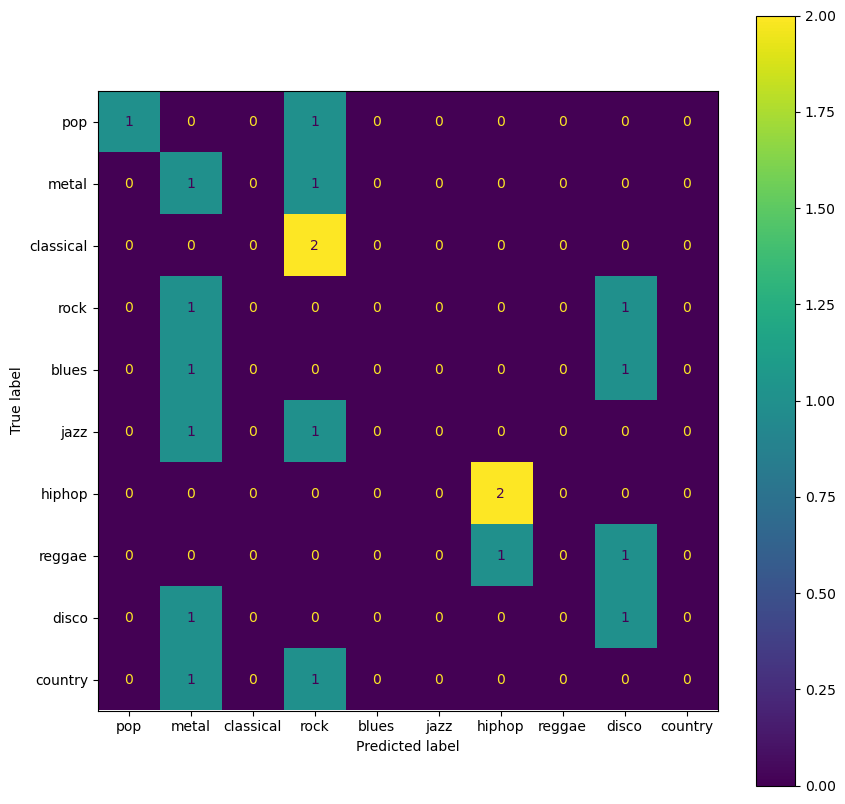

In [20]:
#use the function to print the confusion matrix
print_ConfusionMatrix()

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/ln/rh_16fds3c3f6zwtz0w3p1ww0000gp/T/ipykernel_4176/2749448222.py:31: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  x_beat = librosa.beat.tempo(y=x, sr=Fs, onset_envelope = s_flux, hop_length=H)


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Loading of the model with the parameters combination: svc(C=1, kernel=linear, N=2048, H=128)
Accuracy: 25.0 % given the parameters C = 1 , kernel = linear , N = 2048 and H = 128


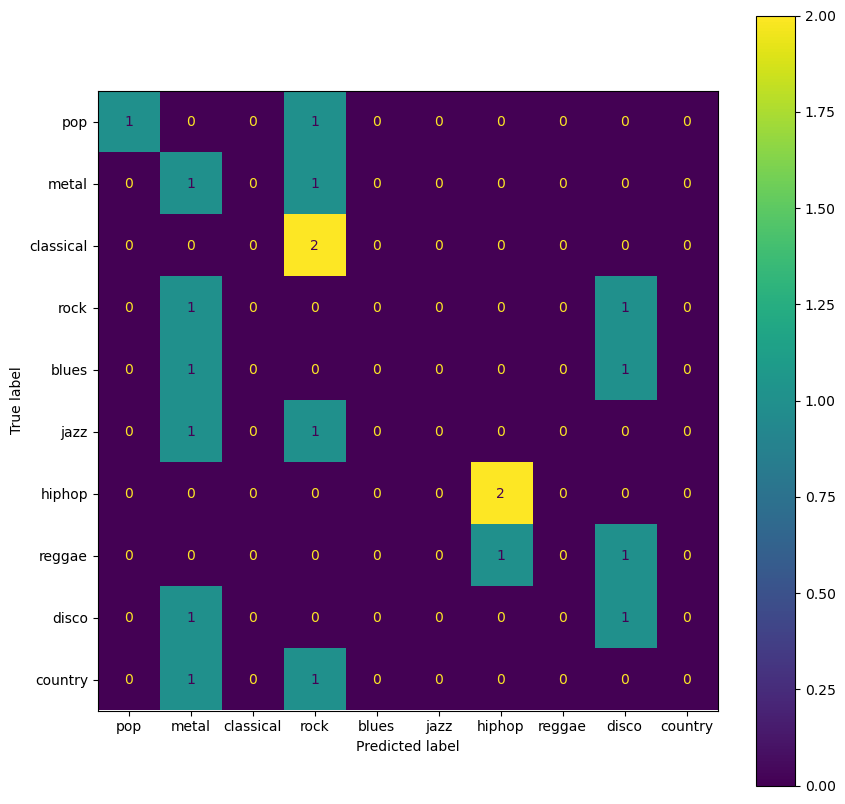

In [21]:
#use the following code to try different parameters cobination in order to find the best model

#This first cell is used simply to check if everything works fine
N = 2048
H = 128
C = 1
kernel = "linear"


#compute the feature vectors
train_fvector, test_fvector = compute_fvectors()

#create the model and train it 
model = SVC(C=C, kernel=kernel)
model.fit(train_fvector, genre_train)

#save and load or just load the model if it already exists
save_and_load_Model()

#compute the prediction list
prediction = model.predict(test_fvector)

#print the accuracy of the model 
print_accuracy(test_fvector, genre_test)

#compute and print the confusion matrix
print_ConfusionMatrix()


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=798
  warnings.warn(
/var/folders/ln/rh_16fds3c3f6zwtz0w3p1ww0000gp/T/ipykernel_4176/2749448222.py:31: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  x_beat = librosa.beat.tempo(y=x, sr=Fs, onset_envelope = s_flux, hop_length=H)


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Creation of the model with the parameters combination: svc(C=1, kernel=rbf, N=2048, H=800)
Loading of the model with the parameters combination: svc(C=1, kernel=rbf, N=2048, H=800)
Accuracy: 35.0 % given the parameters C = 1 , kernel = rbf , N = 2048 and H = 800


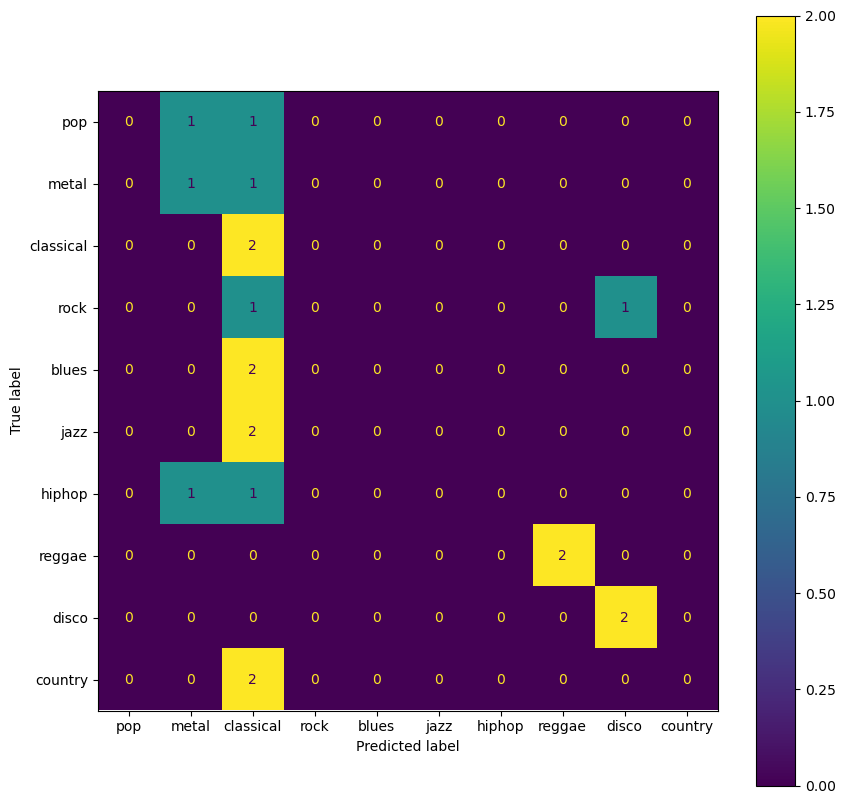

In [22]:
#BEST COMBINATION!
#set the parameters 
N = 2048
H = 800
C = 1
kernel = "rbf"


#compute the feature vectors
train_fvector, test_fvector = compute_fvectors()

#create the model and train it 
model = SVC(C=C, kernel=kernel)
model.fit(train_fvector, genre_train)

#save and load or just load the model if it already exists
save_and_load_Model()

#copute the prediction list
prediction = model.predict(test_fvector)

#print the accuracy of the model 
print_accuracy(test_fvector, genre_test)

#copute and print the confusion matrix
print_ConfusionMatrix()

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=798
  warnings.warn(
/var/folders/ln/rh_16fds3c3f6zwtz0w3p1ww0000gp/T/ipykernel_4176/2749448222.py:31: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  x_beat = librosa.beat.tempo(y=x, sr=Fs, onset_envelope = s_flux, hop_length=H)


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Loading of the model with the parameters combination: svc(C=1, kernel=rbf, N=2048, H=800)
Accuracy: 35.0 % given the parameters C = 1 , kernel = rbf , N = 2048 and H = 800


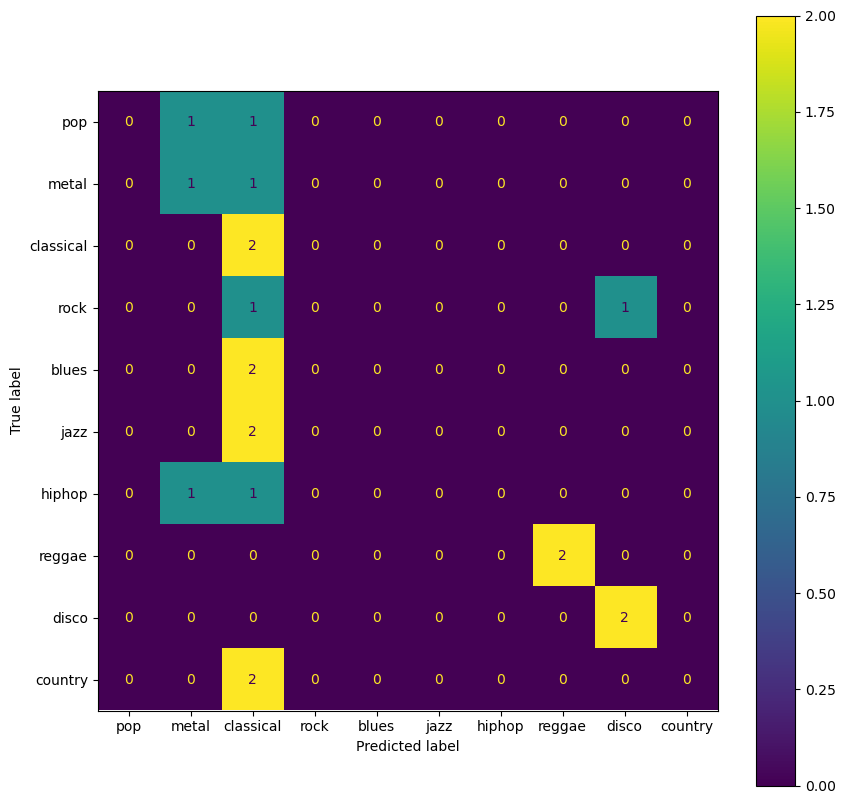

In [23]:
#ANOTHER BEST COMBINATION!
#this cell explain how changing the C value decreases the accuracy related to the training set and increases the one related to the test set 
#we can compare this cell to the following one
#both use the kernel "linear" but with different C values

#this cell provide the same result as the best model obtained with a kernel "rbf" and a higher value of C 
#set the parameters 
N = 2048
H = 800
C = 0.0000000000001
kernel = "linear"


#compute the feature vectors
train_fvector_noC, test_fvector = compute_fvectors()

#create the model and train it 
model = SVC(C=C, kernel=kernel)
model.fit(train_fvector, genre_train)

#save and load or just load the model if it already exists
save_and_load_Model()

#copute the prediction list
prediction = model.predict(test_fvector)


#print the accuracy of the model 
print_accuracy(test_fvector, genre_test)

#copute and print the confusion matrix
print_ConfusionMatrix()

#print the prediction list if you want to compare it with the confusion matrix
#print('Prediction list: ', prediction)

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=798
  warnings.warn(
/var/folders/ln/rh_16fds3c3f6zwtz0w3p1ww0000gp/T/ipykernel_4176/2749448222.py:31: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  x_beat = librosa.beat.tempo(y=x, sr=Fs, onset_envelope = s_flux, hop_length=H)


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/universita/miniconda3/envs/CM2023/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of the trainig set: 
Accuracy: 40.0 % given the parameters C = 1e-13 , kernel = rbf , N = 2048 and H = 800
Creation of the model with the parameters combination: svc(C=1e-13, kernel=rbf, N=2048, H=800)
Loading of the model with the parameters combination: svc(C=1e-13, kernel=rbf, N=2048, H=800)
Accuracy of the test set: 
Accuracy: 35.0 % given the parameters C = 1e-13 , kernel = rbf , N = 2048 and H = 800


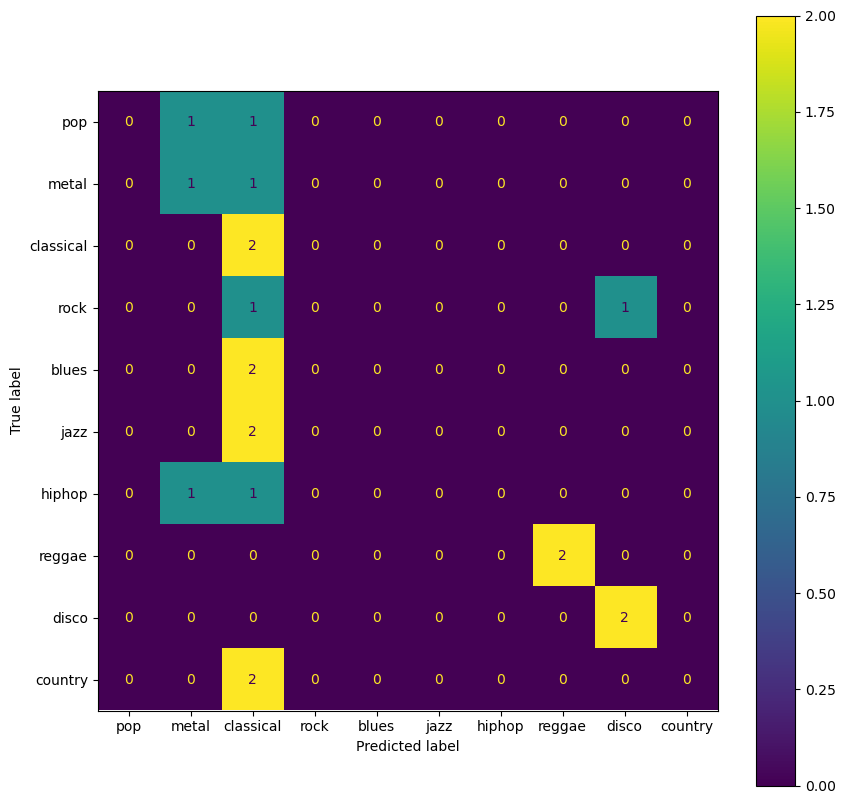

In [24]:
#compare this cell with the previous one
#set the parameters of the model
N = 2048
H = 800
C = 1
kernel = "linear"


#compute the feature vectors
train_fvector, test_fvector = compute_fvectors()

#create the model and train it 
model = SVC(C=C, kernel=kernel)
model.fit(train_fvector, genre_train)

print("Accuracy of the trainig set: ")
print_accuracy(train_fvector, genre_train) 

#save and load or just load the model if it already exists
save_and_load_Model()

#copute the prediction list
prediction = model.predict(test_fvector)


#print the accuracy of the model 
print("Accuracy of the test set: ")
print_accuracy(test_fvector, genre_test)

#copute and print the confusion matrix
print_ConfusionMatrix()


#print the prediction list if you want to compare it with the confusion matrix
#print('Prediction list: ', prediction)